In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('/dbfs/FileStore/tables/daily_weather.csv')

In [3]:
tfrom pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import VectorAssembler,StringIndexer,VectorIndexer

In [4]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('/FileStore/tables/daily_weather.csv',format = 'com.databricks.spark.csv',header='true',inferSchema='true')

In [5]:
df.columns

Out[ 6 ]: 
['number',
 'air_pressure_9am',
 'air_temp_9am',
 'avg_wind_direction_9am',
 'avg_wind_speed_9am',
 'max_wind_direction_9am',
 'max_wind_speed_9am',
 'rain_accumulation_9am',
 'rain_duration_9am',
 'relative_humidity_9am',
 'relative_humidity_3pm']

In [6]:
featureColumns = ['air_pressure_9am','air_temp_9am','avg_wind_direction_9am','avg_wind_speed_9am',
        'max_wind_direction_9am','max_wind_speed_9am','rain_accumulation_9am',
        'rain_duration_9am']

In [7]:
df.count(),len(df.columns)

Out[ 9 ]: (1064, 11)

In [8]:
binarizer = Binarizer(threshold=24.99999,inputCol="relative_humidity_3pm",outputCol="label")
binarizedDF = binarizer.transform(df)

In [9]:
binarizedDF.describe()

Out[ 13 ]: DataFrame[summary: string, number: string, air_pressure_9am: string, air_temp_9am: string, avg_wind_direction_9am: string, avg_wind_speed_9am: string, max_wind_direction_9am: string, max_wind_speed_9am: string, rain_accumulation_9am: string, rain_duration_9am: string, relative_humidity_9am: string, relative_humidity_3pm: string, label: string]

In [10]:
binarizedDF.select("relative_humidity_3pm","label").show(4)

+---------------------+-----+
relative_humidity_3pm|label|
+---------------------+-----+
 36.160000000000494| 1.0|
 19.4265967985621| 0.0|
 14.460000000000045| 0.0|
 12.742547353761848| 0.0|
+---------------------+-----+
only showing top 4 rows

In [11]:
assembler = VectorAssembler(inputCols=featureColumns,outputCol="features")
assembled = assembler.transform(binarizedDF)

In [12]:
assembled.printSchema()

root
-- number: integer (nullable = true)
-- air_pressure_9am: double (nullable = true)
-- air_temp_9am: double (nullable = true)
-- avg_wind_direction_9am: double (nullable = true)
-- avg_wind_speed_9am: double (nullable = true)
-- max_wind_direction_9am: double (nullable = true)
-- max_wind_speed_9am: double (nullable = true)
-- rain_accumulation_9am: double (nullable = true)
-- rain_duration_9am: double (nullable = true)
-- relative_humidity_9am: double (nullable = true)
-- relative_humidity_3pm: double (nullable = true)
-- label: double (nullable = true)
-- features: vector (nullable = true)

In [13]:
(trainingData,testData) = assembled.randomSplit([0.8,0.2],seed = 13234)

In [14]:
dt = DecisionTreeClassifier(labelCol="label",featuresCol="features",maxDepth=5,minInstancesPerNode=20,impurity="gini")

In [15]:
pipeline = Pipeline(stages=[dt])

In [16]:
model = pipeline.fit(trainingData)

In [17]:
predictions = model.transform(testData)

In [18]:
predictions.select("prediction","label").show(20)

+----------+-----+
prediction|label|
+----------+-----+
 0.0| 0.0|
 0.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 0.0| 0.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 0.0|
 1.0| 1.0|
 1.0| 1.0|
 0.0| 0.0|
 1.0| 0.0|
 0.0| 0.0|
 1.0| 1.0|
 0.0| 0.0|
 1.0| 1.0|
 0.0| 0.0|
+----------+-----+
only showing top 20 rows

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
df.show(10)

+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
number| air_pressure_9am| air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|max_wind_speed_9am|rain_accumulation_9am|rain_duration_9am|relative_humidity_9am|relative_humidity_3pm|
+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
 0|918.0600000000087| 74.82200000000041| 271.1| 2.080354199999768| 295.39999999999986| 2.863283199999908| 0.0| 0.0| 42.42000000000046| 36.160000000000494|
 1|917.3476881177097| 71.40384263106537| 101.93517935618371|2.4430092157340217| 140.47154847112498|3.5333236016106238| 0.0| 0.0| 24.328697291802207| 19.4265967985621|
 2|923.0400000000084|60.637999999998776| 51.000000000000036|17.067852199999727| 63.6999999999999|22.100967200000003| 0.0| 20.0| 8.900000000000047| 14.460000000000045|
 3|920.5027511759195| 70.13889486830053| 198.83213271746368| 4.337363056162703| 211.20334124325618| 5.190045360219378| 0.0| 0.0| 12.189101868764444| 12.742547353761848|
 4|921.1600000000036| 44.29400000000284| 277.8|1.8566601999998955| 136.49999999999991| 2.863283199999954| 8.899999999998613| 14730.0| 92.41000000000044| 76.74000000000046|
 5| 915.300000000006| 78.40400000000422| 182.8| 9.93201359999979| 188.99999999999986|10.983375399999995| 0.02000000000043656| 170.0| 35.130000000000265| 33.930000000000256|
 6|915.5988675132801| 70.04330431686239| 177.87540718659943|3.7455865377244795| 186.60669587586753| 4.589632428699432| 0.0| 0.0| 10.657421657822635| 21.385656725200974|
 7|918.0700000000023|51.710000000002346| 242.4| 2.527742199999939| 271.5999999999999|3.6462121999999924| 0.0| 0.0| 80.47000000000041| 74.92000000000041|
 8| 920.080000000006| 80.58200000000384| 40.7| 4.518618799999764| 62.99999999999986| 5.883152199999977| 0.0| 0.0| 29.58000000000045| 24.030000000000427|
 9|915.0100000000116| 47.4979999999998| 163.10000000000005| 4.943637399999545| 195.89999999999992| 6.576603599999951| 0.0| 0.0| 88.6000000000012| 68.0500000000012|
+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
only showing top 10 rows

In [20]:
predictions = sqlContext.read.load('/FileStore/tables/Predictions.csv',format = 'com.databricks.spark.csv',header='true',inferSchema='true')

In [21]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")

In [22]:
accuracy = evaluator.evaluate(predictions)

In [23]:
predictions.show(10)

+----------+-----+
prediction|label|
+----------+-----+
 1.0| 1.0|
 0.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 0.0| 1.0|
 1.0| 1.0|
+----------+-----+
only showing top 10 rows

In [24]:
print("Accuracy = %g " % (accuracy))

Accuracy = 0.795122

In [25]:
predictions.rdd.take(2)

Out[ 37 ]: [Row(prediction=1.0, label=1.0), Row(prediction=0.0, label=1.0)]

In [26]:
predictions.rdd.map(tuple).take(2)

Out[ 69 ]: [(1.0, 1.0), (0.0, 1.0)]

In [27]:
metrics = MulticlassMetrics(predictions.rdd.map(tuple))

In [28]:
metrics.confusionMatrix().toArray().transpose()

Out[ 39 ]: 
array([[ 85., 19.],
 [ 23., 78.]])

In [29]:
print ("Error = %g " % (1.0 - accuracy))

Error = 0.204878

In [30]:
print ("Accuracy = %.2g" % (accuracy * 100))

Accuracy = 80

In [31]:
metrics.confusionMatrix().toArray()

Out[ 73 ]: 
array([[ 85., 23.],
 [ 19., 78.]])

In [32]:
df1.corr

Out[ 92 ]: 
<bound method DataFrame.corr of number air_pressure_9am air_temp_9am avg_wind_direction_9am \
0 0 918.060000 74.822000 271.100000 
1 1 917.347688 71.403843 101.935179 
2 2 923.040000 60.638000 51.000000 
3 3 920.502751 70.138895 198.832133 
4 4 921.160000 44.294000 277.800000 
5 5 915.300000 78.404000 182.800000 
6 6 915.598868 70.043304 177.875407 
7 7 918.070000 51.710000 242.400000 
8 8 920.080000 80.582000 40.700000 
9 9 915.010000 47.498000 163.100000 
10 10 919.650000 77.036000 70.600000 
11 11 915.640000 45.716000 241.600000 
12 12 917.390000 49.784000 204.100000 
13 13 920.820000 62.438000 213.600000 
14 14 911.000000 86.432000 202.900000 
15 15 922.383131 70.865263 36.174175 
16 16 917.890000 NaN 169.200000 
17 17 916.915255 77.018961 234.539345 
18 18 918.800000 67.082000 176.100000 
19 19 922.040000 68.576000 58.300000 
20 20 919.992262 62.964383 54.799094 
21 21 917.230000 67.676000 177.800000 
22 22 921.125626 68.818772 71.799092 
23 23 920.350000 47.570000 192.100000 
24 24 921.788229 71.659572 217.405520 
25 25 918.030000 50.666000 128.900000 
26 26 914.490000 49.892000 163.000000 
27 27 914.900000 78.620000 203.300000 
28 28 915.840000 40.118000 171.900000 
29 29 916.310000 45.428000 183.100000 
... ... ... ... ... 
1065 1065 915.600000 69.584000 185.500000 
1066 1066 919.564869 73.726732 68.704694 
1067 1067 917.690000 64.994000 178.300000 
1068 1068 920.330000 68.864000 122.400000 
1069 1069 918.260000 82.220000 186.600000 
1070 1070 911.600000 46.346000 110.200000 
1071 1071 919.200000 70.250000 156.700000 
1072 1072 923.100000 75.596000 178.300000 
1073 1073 917.920000 84.650000 30.000000 
1074 1074 913.870000 66.938000 171.900000 
1075 1075 922.858110 64.989361 63.483047 
1076 1076 925.550000 50.918000 32.600000 
1077 1077 920.130000 73.292000 193.600000 
1078 1078 924.017856 68.370307 56.304083 
1079 1079 917.200000 65.264000 137.600000 
1080 1080 916.260000 79.772000 185.700000 
1081 1081 920.856913 69.884338 47.335966 
1082 1082 916.130000 50.108000 211.400000 
1083 1083 916.320000 48.308000 46.900000 
1084 1084 917.130000 80.240000 183.300000 
1085 1085 914.840000 47.354000 190.900000 
1086 1086 921.260000 52.646000 261.900000 
1087 1087 914.000000 66.650000 173.800000 
1088 1088 912.900000 71.870000 129.200000 
1089 1089 915.000000 55.040000 191.800000 
1090 1090 918.900000 63.104000 192.900000 
1091 1091 918.710000 49.568000 241.600000 
1092 1092 916.600000 71.096000 189.300000 
1093 1093 912.600000 58.406000 172.700000 
1094 1094 921.530000 77.702000 97.100000 

 avg_wind_speed_9am max_wind_direction_9am max_wind_speed_9am \
0 2.080354 295.400000 2.863283 
1 2.443009 140.471548 3.533324 
2 17.067852 63.700000 22.100967 
3 4.337363 211.203341 5.190045 
4 1.856660 136.500000 2.863283 
5 9.932014 189.000000 10.983375 
6 3.745587 186.606696 4.589632 
7 2.527742 271.600000 3.646212 
8 4.518619 63.000000 5.883152 
9 4.943637 195.900000 6.576604 
10 3.825167 85.500000 4.764682 
11 5.860783 265.800000 8.030615 
12 1.275056 211.800000 2.013246 
13 2.617220 165.700000 3.310671 
14 1.207948 162.900000 1.677705 
15 1.847278 58.428632 2.529142 
16 2.192201 196.800000 2.930391 
17 2.274725 229.474199 2.906513 
18 4.876529 183.400000 5.569981 
19 9.551734 81.900000 12.571603 
20 12.680436 74.254223 15.452306 
21 2.460634 93.200000 3.288302 
22 2.576538 95.472334 3.487444 
23 6.263432 205.700000 7.605596 
24 1.946447 253.758003 2.719712 
25 2.527742 117.400000 4.004123 
26 4.854160 189.600000 6.733189 
27 1.811921 240.000000 2.751436 
28 10.535987 188.000000 12.929513 
29 8.343786 194.600000 10.088599 
... ... ... ... 
1065 4.630466 198.200000 5.480503 
1066 3.551777 102.571616 4.861315 
1067 2.975130 193.900000 3.735690 
1068 2.035615 182.000000 3.086977 
1069 1.096101 221.500000 1.722444 
1070 2.304048 96.100000 3.154085 
1071 2.013246 172.300000 2.617220 
1072 1.409272 205.200000 1.856660 
1073 4.831790 40.100000 5.838413 
1074 6.509495 182.300000 7.471380 
1075 10.261187 73.170504 11.949206 
1076 5.

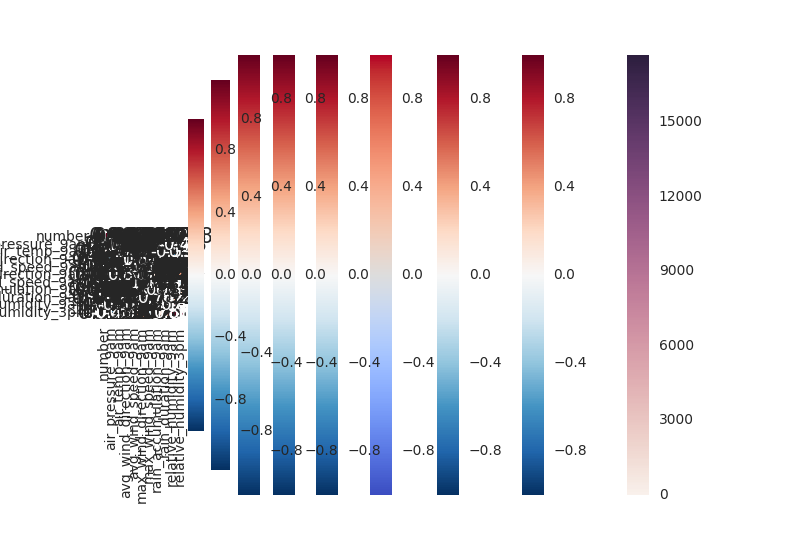

In [33]:
svm=display(sns.heatmap(df1.corr(),annot=True).figure)

In [34]:
plt.savefig('svm_conf.jpg', dpi=400)  